In [1]:
# import libraries
import os 
import csv
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image
import glob
from PIL import ImageFile
from sklearn.cluster import KMeans
import transformers
from sentence_transformers import SentenceTransformer
from PIL import Image, UnidentifiedImageError
import sklearn
ImageFile.LOAD_TRUNCATED_IMAGES = True
import re
import random
from spellchecker import SpellChecker
import inflect


In [3]:
df = pd.read_csv('final_data_exploration.csv')

In [7]:
# perfrom clusterin on label with clusters size 2 use tdidf to vectorize the label
model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(df['label'], convert_to_tensor=True)
kmeans = KMeans(n_clusters=2, n_init='auto', max_iter=1000, random_state=42).fit(embeddings.cpu())
cluster_labels = kmeans.labels_
label_to_cluster = dict(zip(df['label'], cluster_labels))

df['cluster_2'] = df['label'].map(label_to_cluster)

df

/home/trkosire/Factorynet/hack_env/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set th

,label,x1,y1,height,width,source,file_name,cluster_2
0,railway grinding machine,0.0,0.0,720.0,720.0,user,1711591656377,1
1,rail grinder,0.0,0.0,720.0,720.0,user,1711591656377,1
2,rail grinder with worker,0.0,0.0,720.0,720.0,user,1711591656377,1
3,railway grinding machine with worker,0.0,0.0,720.0,720.0,user,1711591656377,1
4,worker,0.0,0.0,720.0,720.0,user,1711591656377,1
...,...,...,...,...,...,...,...,...
23296,minibar t,0.0,0.0,2660.0,4000.0,wikimedia,1711580020679,0
23297,rail clamp,0.0,0.0,605.0,907.0,user,1711581093292,0
23298,patrol rail fastening,0.0,0.0,2304.0,3456.0,wikimedia,1711581093292,0
23299,drill bit,0.0,0.0,651.0,907.0,user,1711566352395,1


In [20]:
df.to_csv('two_clusters_file.csv', index=False)

In [23]:
# exctract all images from the bounding boxes given in the file and same then in a separate folder

def extract_bounding_boxes(df, image_dir, csv_dir, output_dir):
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    # Process each CSV file
    for i, row in df.iterrows():
        image_name = row['file_name'] 
        image_path = os.path.join(image_dir, str(image_name) + '.png')
        
        # Check if the image exists
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        # Load the image
        try:
            image = Image.open(image_path)
        except IOError:
            print(f"Error opening image: {image_path}")
            continue

    
        label = row['label']
        x1, y1 = int(row['x1']), int(row['y1'])
        height, width = int(row['height']), int(row['width'])

        # Use the whole image if x1 == 0 and y1 == 0
        if x1 == 0 and y1 == 0:
            bbox_image = image
        else:
            # Ensure width and height are within image bounds
            real_width, real_height = image.size
            if height == 0:
                height = real_height - y1
            if width == 0:
                width = real_width - x1

            # Calculate x2, y2
            x2, y2 = x1 + width, y1 + height

            # Extract the bounding box
            bbox_image = image.crop((x1, y1, x2, y2))

        # Generate a unique filename for the bounding box image
        bbox_filename = f"{i}_{image_name}_{label}.png"
        bbox_path = os.path.join(output_dir, bbox_filename)

        # Save the bounding box image
        try:
            if bbox_image.mode  != 'RGB':
                bbox_image = bbox_image.convert('RGB')
            bbox_image.save(bbox_path)

            # add the image name in the df in place of the file name
            df.at[i, 'file_name'] = bbox_filename

        except Exception as e:
            print(f"Error processing image file with boynding box: {image} - {str(e)}")
            continue

    print("Extraction complete")

# Usage
image_dir = "/home/trkosire/Factorynet/hackathon/data/"
csv_dir = "/home/trkosire/Factorynet/hackathon/data/"
output_dir = "/home/trkosire/Factorynet/hackathon/all_images/"
extract_bounding_boxes(df, image_dir, csv_dir, output_dir)

/home/trkosire/Factorynet/hack_env/lib/python3.8/site-packages/PIL/JpegImagePlugin.py:846: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Error opening image: /home/trkosire/Factorynet/hackathon/data/1711579699090.png
Error opening image: /home/trkosire/Factorynet/hackathon/data/1711575250715.png
Error opening image: /home/trkosire/Factorynet/hackathon/data/1711604541829.png
Error opening image: /home/trkosire/Factorynet/hackathon/data/1711579717147.png


/home/trkosire/Factorynet/hack_env/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (96000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Error opening image: /home/trkosire/Factorynet/hackathon/data/1711603801889.png
Error opening image: /home/trkosire/Factorynet/hackathon/data/1711603801889.png
Error opening image: /home/trkosire/Factorynet/hackathon/data/1711593511447.png
Error opening image: /home/trkosire/Factorynet/hackathon/data/1711593511447.png


/home/trkosire/Factorynet/hack_env/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (138951232 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Extraction complete


In [ ]:
df[df['file_name'].str.contains('1711579699090.png')]

In [24]:
df

,label,x1,y1,height,width,source,file_name,cluster_2
0,railway grinding machine,0.0,0.0,720.0,720.0,user,0_1711591656377_railway grinding machine.png,1
1,rail grinder,0.0,0.0,720.0,720.0,user,1_1711591656377_rail grinder.png,1
2,rail grinder with worker,0.0,0.0,720.0,720.0,user,2_1711591656377_rail grinder with worker.png,1
3,railway grinding machine with worker,0.0,0.0,720.0,720.0,user,3_1711591656377_railway grinding machine with ...,1
4,worker,0.0,0.0,720.0,720.0,user,4_1711591656377_worker.png,1
...,...,...,...,...,...,...,...,...
23296,minibar t,0.0,0.0,2660.0,4000.0,wikimedia,23296_1711580020679_minibar t.png,0
23297,rail clamp,0.0,0.0,605.0,907.0,user,23297_1711581093292_rail clamp.png,0
23298,patrol rail fastening,0.0,0.0,2304.0,3456.0,wikimedia,23298_1711581093292_patrol rail fastening.png,0
23299,drill bit,0.0,0.0,651.0,907.0,user,23299_1711566352395_drill bit.png,1


In [25]:
df.to_csv('two_clusters_file.csv', index=False)

In [31]:
df.isnull().sum()

label        0
x1           0
y1           0
height       0
width        0
source       0
file_name    0
cluster_2    0
dtype: int64

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# set random seed 
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
batch_size = 64
leaning_rate = 0.001

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


cluster_zero_df = df[df['cluster_2'] == 0]
cluster_one_df = df[df['cluster_2'] == 1]

# drop rows with missing images
cluster_zero_df = cluster_zero_df[cluster_zero_df['file_name'].apply(lambda x: os.path.exists(os.path.join(output_dir, str(x))))]
cluster_one_df = cluster_one_df[cluster_one_df['file_name'].apply(lambda x: os.path.exists(os.path.join(output_dir, str(x))))]

# create a dataset for each cluster
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_dir, str(row['file_name']))
        image = Image.open(image_path)
        label = row['cluster_2']
        if self.transform:
            image = self.transform(image)
        return image, label
    
cluster_zero_images = CustomDataset(cluster_zero_df, output_dir, transform)
cluster_one_images = CustomDataset(cluster_one_df, output_dir, transform)

# combine the datasets
combined_dataset = torch.utils.data.ConcatDataset([cluster_zero_images, cluster_one_images])

# get the labels
labels = [label for _, label in combined_dataset]

# perform stratified split
X_train, X_test, y_train, y_test = train_test_split(combined_dataset, labels, test_size=0.2, stratify=labels, random_state=42)

# create dataloaders
train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=True)

# # load the resnet model
# model1 = torchvision.models.resnet152(pretrained=True)
# model1 = torch.nn.DataParallel(model1)
# model1 = model1.to(device)
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model1.parameters(), lr=leaning_rate)
# training_loss = []
# testing_loss = []
 
#  # change the last layer of the model to have 2 outputs
# num_ftrs = model1.module.fc.in_features
# model1.module.fc = torch.nn.Linear(num_ftrs, 2)
# model1 = model1.to(device)


# def test_loss(loader, model1):
#     model1.eval()
#     with torch.no_grad():
#         total_loss = 0
#         for images, labels in loader:
#             labels = labels.type(torch.LongTensor)
#             images = images.to(device)
#             labels = labels.to(device)
#             outputs = model1(images)
#             loss = criterion(outputs, labels)
#             total_loss += loss.item()
#         model1.train()
#         return total_loss / len(loader)
# i = 0
# for epoch in range(num_epochs):
#     for images, labels in train_loader:
#         labels = labels.type(torch.LongTensor)
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model1(images)
#         loss = criterion(outputs, labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         if i % 1000 == 0:
#             print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")
#             training_loss.append(loss.item()) 
#             testing_loss.append(test_loss(test_loader, model1))
#         i += 1
        
# # save the model as model number 1 
# torch.save(model1.state_dict(), 'model1.pth')

In [76]:
from torchvision.models import resnet50, ResNet50_Weights
import torch
import torchvision
from torch.utils.data import DataLoader

# Assuming train_loader and test_loader are defined elsewhere
# Assuming device is defined (e.g., device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Hyperparameters
momentum = 0.9
initial_learning_rate = 0.1
learning_rate_decay = 0.1
weight_decay = 0.0002
num_epochs = 10
batch_size = 128

# Model setup
model1 = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
model1 = torch.nn.DataParallel(model1)
num_ftrs = model1.module.fc.in_features
model1.module.fc = torch.nn.Linear(num_ftrs, 2)
model1 = model1.to(device)

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=initial_learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15000, gamma=learning_rate_decay)

# Training loop
training_loss = []
testing_loss = []

def test_loss(loader, model1):
    model1.eval()
    with torch.no_grad():
        total_loss = 0
        for images, labels in loader:
            labels = labels.type(torch.LongTensor)
            images = images.to(device)
            labels = labels.to(device)
            outputs = model1(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
        model1.train()
        return total_loss / len(loader)

for epoch in range(num_epochs):
    model1.train()
    running_loss = 0.0
    for images, labels in train_loader:
        labels = labels.type(torch.LongTensor)
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model1(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item()
    
    # Adjust learning rate
    scheduler.step()
    
    # Calculate average training loss
    avg_training_loss = running_loss / len(train_loader)
    training_loss.append(avg_training_loss)
    
    # Calculate testing loss
    avg_testing_loss = test_loss(test_loader, model1)
    testing_loss.append(avg_testing_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_training_loss:.4f}, Testing Loss: {avg_testing_loss:.4f}')

Epoch [1/10], Training Loss: 0.6818, Testing Loss: 0.6750
Epoch [2/10], Training Loss: 0.6747, Testing Loss: 0.6780
Epoch [3/10], Training Loss: 0.6646, Testing Loss: 0.6913
Epoch [4/10], Training Loss: 0.6573, Testing Loss: 0.7113
Epoch [5/10], Training Loss: 0.6536, Testing Loss: 0.6548
Epoch [6/10], Training Loss: 0.6434, Testing Loss: 0.6855
Epoch [7/10], Training Loss: 0.6353, Testing Loss: 0.6526
Epoch [8/10], Training Loss: 0.6231, Testing Loss: 0.6969
Epoch [9/10], Training Loss: 0.6171, Testing Loss: 0.6673
Epoch [10/10], Training Loss: 0.6105, Testing Loss: 0.6759


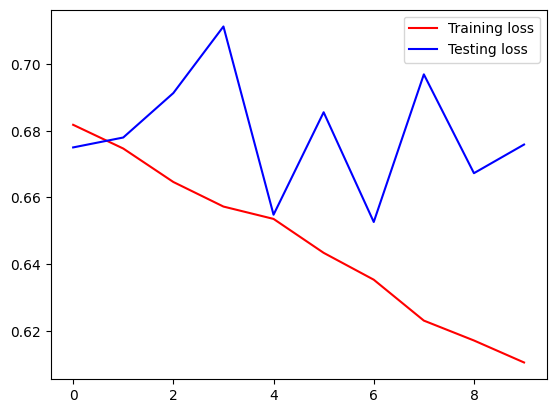

In [77]:
plt.plot(training_loss, label='Training loss', color = 'red')
plt.plot(testing_loss, label='Testing loss', color = 'blue')
plt.legend()
plt.show()

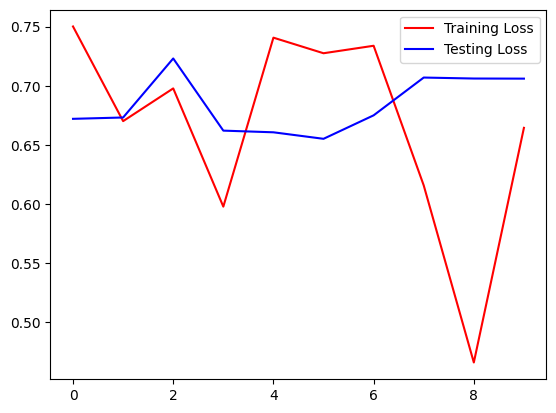

In [61]:
# scale training and testing loss between 0 and 1
min_train_loss = min(training_loss)
max_train_loss = max(training_loss)
min_test_loss = min(testing_loss)
max_test_loss = max(testing_loss)

scaled_training_loss = [(loss - min_train_loss) / (max_train_loss - min_train_loss) for loss in training_loss]
scaled_testing_loss = [(loss - min_test_loss) / (max_test_loss - min_test_loss) for loss in testing_loss]
# plot training and testing loss
plt.plot(training_loss, label='Training Loss',color = 'red')
plt.plot(testing_loss, label='Testing Loss', color = 'blue')
plt.legend()
plt.show()

In [63]:
zero_cluster = df[df['cluster_2'] == 0].reset_index(drop=True)
one_cluster = df[df['cluster_2'] == 1].reset_index(drop=True)

model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(zero_cluster['label'], convert_to_tensor=True)
kmeans = KMeans(n_clusters=2, n_init='auto', max_iter=1000, random_state=42).fit(embeddings.cpu())
cluster_labels = kmeans.labels_
label_to_cluster = dict(zip(zero_cluster['label'], cluster_labels))

zero_cluster['cluster_4'] = zero_cluster['label'].map(label_to_cluster)



embeddings = model.encode(one_cluster['label'], convert_to_tensor=True)
kmeans = KMeans(n_clusters=2, n_init='auto', max_iter=1000, random_state=42).fit(embeddings.cpu())
cluster_labels = kmeans.labels_
label_to_cluster = dict(zip(one_cluster['label'], cluster_labels))

one_cluster['cluster_4'] = one_cluster['label'].map(label_to_cluster)


two_cluster = zero_cluster[zero_cluster['cluster_4'] == 0].reset_index(drop=True)
three_cluster = zero_cluster[zero_cluster['cluster_4'] == 1].reset_index(drop=True)
four_cluster = one_cluster[one_cluster['cluster_4'] == 0].reset_index(drop=True)
five_cluster = one_cluster[one_cluster['cluster_4'] == 1].reset_index(drop=True)


embeddings = model.encode(two_cluster['label'], convert_to_tensor=True)
kmeans = KMeans(n_clusters=3, n_init='auto', max_iter=1000, random_state=42).fit(embeddings.cpu())
cluster_labels = kmeans.labels_
label_to_cluster = dict(zip(two_cluster['label'], cluster_labels))

two_cluster['cluster_12'] = two_cluster['label'].map(label_to_cluster)

embeddings = model.encode(three_cluster['label'], convert_to_tensor=True)
kmeans = KMeans(n_clusters=3, n_init='auto', max_iter=1000, random_state=42).fit(embeddings.cpu())
cluster_labels = kmeans.labels_
label_to_cluster = dict(zip(three_cluster['label'], cluster_labels))

three_cluster['cluster_12'] = three_cluster['label'].map(label_to_cluster)

embeddings = model.encode(four_cluster['label'], convert_to_tensor=True)
kmeans = KMeans(n_clusters=3, n_init='auto', max_iter=1000, random_state=42).fit(embeddings.cpu())
cluster_labels = kmeans.labels_
label_to_cluster = dict(zip(four_cluster['label'], cluster_labels))

four_cluster['cluster_12'] = four_cluster['label'].map(label_to_cluster)

embeddings = model.encode(five_cluster['label'], convert_to_tensor=True)
kmeans = KMeans(n_clusters=3, n_init='auto', max_iter=1000, random_state=42).fit(embeddings.cpu())
cluster_labels = kmeans.labels_
label_to_cluster = dict(zip(five_cluster['label'], cluster_labels))

five_cluster['cluster_12'] = five_cluster['label'].map(label_to_cluster)

six_cluster = two_cluster[two_cluster['cluster_12'] == 0].reset_index(drop=True)
seven_cluster = two_cluster[two_cluster['cluster_12'] == 1].reset_index(drop=True)
eight_cluster = two_cluster[two_cluster['cluster_12'] == 2].reset_index(drop=True)
nine_cluster = three_cluster[three_cluster['cluster_12'] == 0].reset_index(drop=True)
ten_cluster = three_cluster[three_cluster['cluster_12'] == 1].reset_index(drop=True)
eleven_cluster = three_cluster[three_cluster['cluster_12'] == 2].reset_index(drop=True)
twelve_cluster = four_cluster[four_cluster['cluster_12'] == 0].reset_index(drop=True)
thirteen_cluster = four_cluster[four_cluster['cluster_12'] == 1].reset_index(drop=True)
fourteen_cluster = four_cluster[four_cluster['cluster_12'] == 2].reset_index(drop=True)
fifteen_cluster = five_cluster[five_cluster['cluster_12'] == 0].reset_index(drop=True)
sixteen_cluster = five_cluster[five_cluster['cluster_12'] == 1].reset_index(drop=True)
seventeen_cluster = five_cluster[five_cluster['cluster_12'] == 2].reset_index(drop=True)


/home/trkosire/Factorynet/hack_env/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [64]:
# model 2 for cluster 2  and cluster 3 
model2 = torchvision.models.resnet152(pretrained=True)
model2 = torch.nn.DataParallel(model2)
model2 = model2.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=leaning_rate)
training_loss = []
testing_loss = []



/home/trkosire/Factorynet/hack_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/trkosire/Factorynet/hack_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
